<a href="https://colab.research.google.com/github/ridvanyigit/uskdar-vize/blob/main/YapaySinirAglariVize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Scikit-learn
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
    )

In [ ]:
# Optuna
!pip install optuna

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
# SHAP
import shap

In [ ]:
# Grafik ayarları
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Veri Setinin Yüklenmesi

In [ ]:
data = load_breast_cancer()

In [ ]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

In [ ]:
print("VERİ SETİ BİLGİLERİ:")
print("")
print(f"Özellik sayısı: {X.shape[1]}")
print(f"Örnek sayısı: {X.shape[0]}")
print(f"Hedef değişken sınıfları: {np.unique(y)}")
print(f"Sınıf dağılımı:\n{y.value_counts()}")

VERİ SETİ BİLGİLERİ:

Özellik sayısı: 30
Örnek sayısı: 569
Hedef değişken sınıfları: [0 1]
Sınıf dağılımı:
target
1    357
0    212
Name: count, dtype: int64


In [ ]:
df = X.copy()
df['target'] = y

display(df.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# Eksik Değer Analizi

In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Sütun': missing_values.index,
    'Eksik Değer Sayısı': missing_values.values,
    'Yüzde (%)': missing_percentage.values
})

In [ ]:
missing_df = missing_df[missing_df['Eksik Değer Sayısı'] > 0].sort_values(
    'Eksik Değer Sayısı', ascending=False
)

In [ ]:
if len(missing_df) > 0:
    display(missing_df)
    print("\n Eksik değerler tespit edildi ve uygun yöntemle doldurulacak.")

    for col in missing_df['Sütun']:
        if col != 'target':
            X[col].fillna(X[col].median(), inplace=True)
else:
    print("✓ Veri setinde eksik değer bulunmamaktadır.")

✓ Veri setinde eksik değer bulunmamaktadır.


# Aykırı Değer Analizi (IQR Yöntemi)

In [ ]:
def detect_outliers_iqr(data):
    outliers_dict = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
        outliers_dict[column] = len(outliers)

    return outliers_dict

In [ ]:
outliers = detect_outliers_iqr(X)
outliers_df = pd.DataFrame(list(outliers.items()),
                           columns=['Özellik', 'Aykırı Değer Sayısı'])
outliers_df = outliers_df[outliers_df['Aykırı Değer Sayısı'] > 0].sort_values(
    'Aykırı Değer Sayısı', ascending=False
)

In [ ]:
display(outliers_df.head(10))

print(f"\nToplam {len(outliers_df)} özellikte aykırı değer tespit edildi.")
print("Aykırı değerler modelin performansını etkileyebilir ancak bu veri setinde doğal varyasyonlar olabilir.")

,Özellik,Aykırı Değer Sayısı
13,area error,65
10,radius error,38
12,perimeter error,38
23,worst area,35
14,smoothness error,30
15,compactness error,28
19,fractal dimension error,28
18,symmetry error,27
3,mean area,25
29,worst fractal dimension,24



Toplam 29 özellikte aykırı değer tespit edildi.
Aykırı değerler modelin performansını etkileyebilir ancak bu veri setinde doğal varyasyonlar olabilir.


# Veri Tipi ve Dağılım İncelemesi

In [ ]:
print(f"Shape: {df.shape}")
print(f"Sayısal değişken sayısı: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Kategorik değişken sayısı: {df.select_dtypes(include=['object']).shape[1]}")
print("-" * 40)
print("SÜTUN BİLGİLERİ: \n")
print(df.dtypes)

Shape: (569, 31)
Sayısal değişken sayısı: 31
Kategorik değişken sayısı: 0
--------------------
SÜTUN BİLGİLERİ: 

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compa

# İstatistiksel Özellikler

In [ ]:
stats_df = pd.DataFrame({
    'Mean': X.mean(),
    'Median': X.median(),
    'Std': X.std(),
    'Min': X.min(),
    'Q1': X.quantile(0.25),
    'Q3': X.quantile(0.75),
    'Max': X.max()
})

display(stats_df.head(10))

,Mean,Median,Std,Min,Q1,Q3,Max
mean radius,14.127292,13.37000,3.524049,6.98100,11.70000,15.78000,28.11000
mean texture,19.289649,18.84000,4.301036,9.71000,16.17000,21.80000,39.28000
mean perimeter,91.969033,86.24000,24.298981,43.79000,75.17000,104.10000,188.50000
mean area,654.889104,551.10000,351.914129,143.50000,420.30000,782.70000,2501.00000
mean smoothness,0.096360,0.09587,0.014064,0.05263,0.08637,0.10530,0.16340
mean compactness,0.104341,0.09263,0.052813,0.01938,0.06492,0.13040,0.34540
mean concavity,0.088799,0.06154,0.079720,0.00000,0.02956,0.13070,0.42680
mean concave points,0.048919,0.03350,0.038803,0.00000,0.02031,0.07400,0.20120
mean symmetry,0.181162,0.17920,0.027414,0.10600,0.16190,0.19570,0.30400
mean fractal dimension,0.062798,0.06154,0.007060,0.04996,0.05770,0.06612,0.09744


# Korelasyon Matrisi ve Heatmap

In [ ]:
# Korelasyon matrisi
correlation_matrix = X.corr()

In [ ]:
# En yüksek korelasyonlu çiftleri bulma
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Özellik 1': correlation_matrix.columns[i],
            'Özellik 2': correlation_matrix.columns[j],
            'Korelasyon': correlation_matrix.iloc[i, j]
        })

corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('Korelasyon',
                                                      ascending=False,
                                                      key=abs)

print("En yüksek korelasyonlu 3 özellik çifti:")
display(corr_pairs_df.head(3))

En yüksek korelasyonlu 3 özellik çifti:


,Özellik 1,Özellik 2,Korelasyon
1,mean radius,mean perimeter,0.997855
391,worst radius,worst perimeter,0.993708
2,mean radius,mean area,0.987357


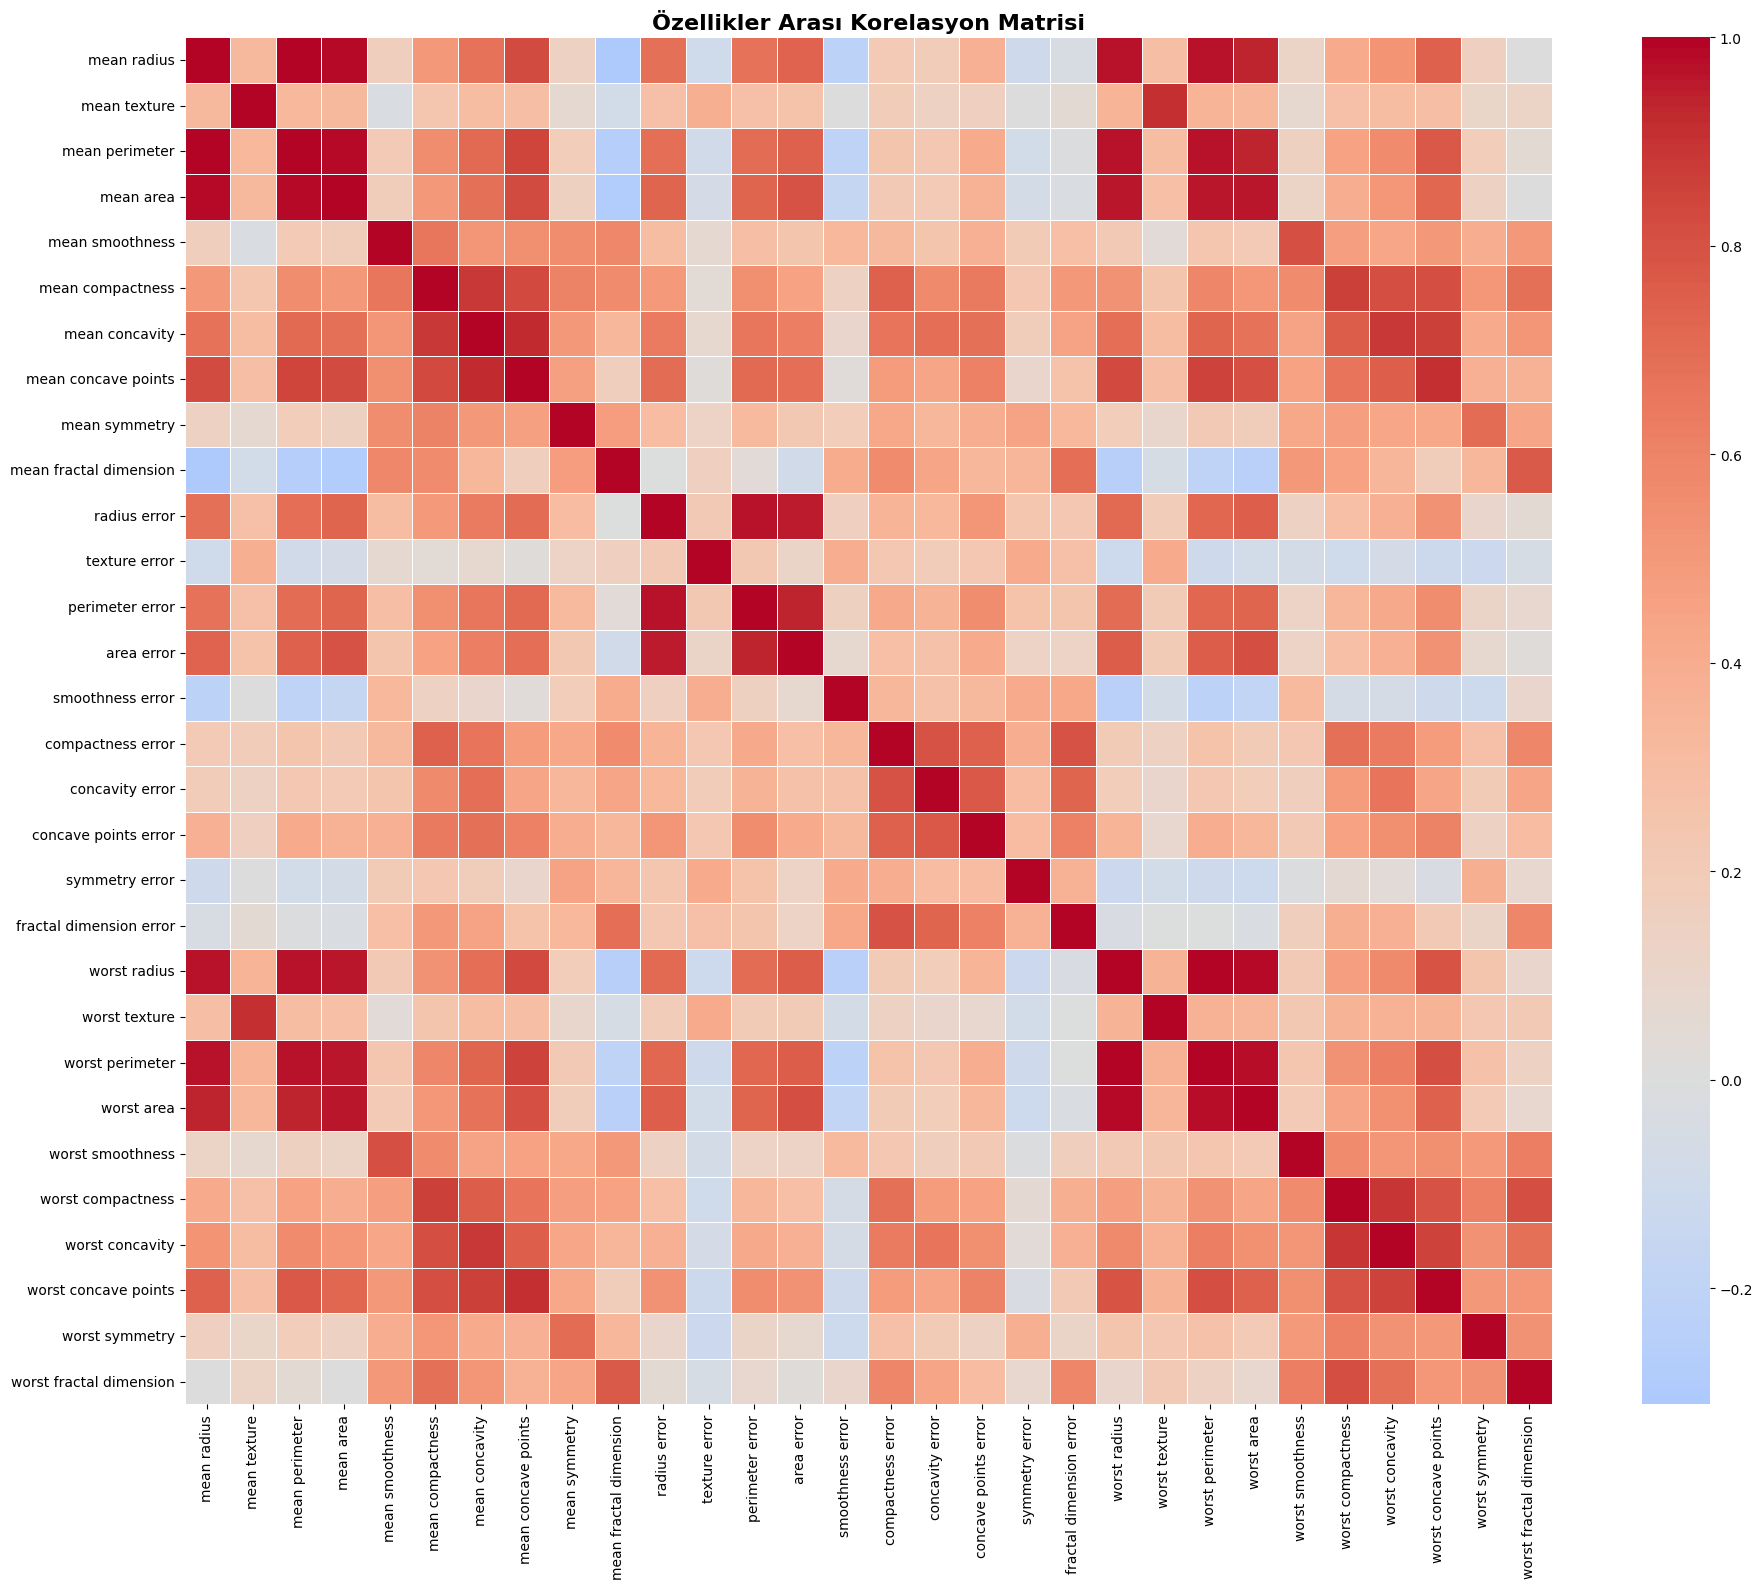


Yüksek korelasyonlu özellikler birbirine benzer bilgiler taşır.
Bu durum multicollinearity'ye neden olabilir ancak neural network'ler bunu handle edebilir.


In [ ]:
# Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nYüksek korelasyonlu özellikler birbirine benzer bilgiler taşır.")
print("Bu durum multicollinearity'ye neden olabilir ancak neural network'ler bunu handle edebilir.")

# Boxplot Analizi

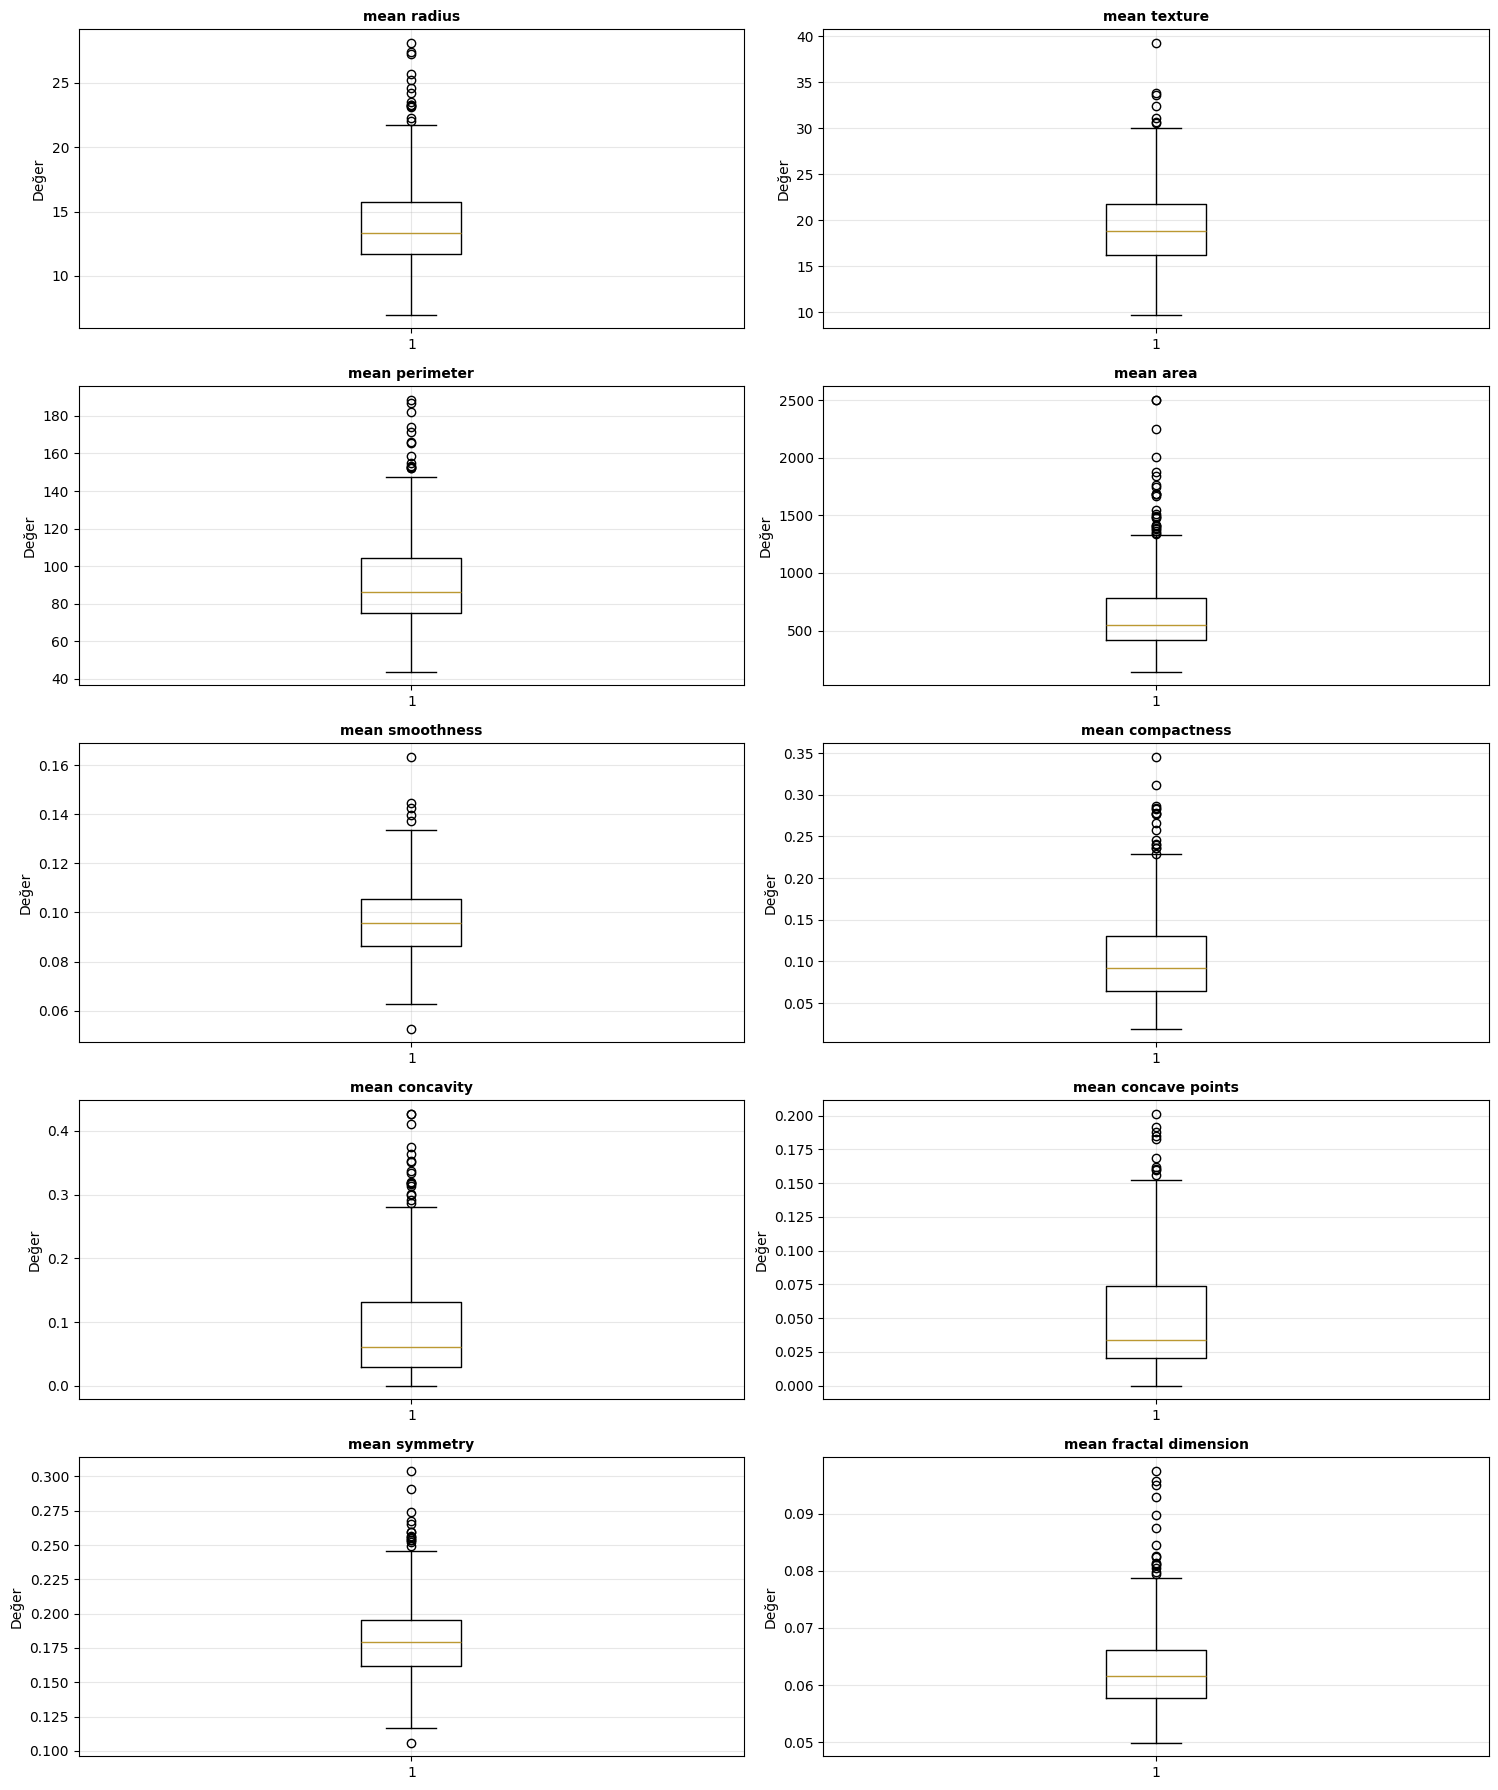


Boxplot'lar aykırı değerleri görselleştirir.
Kutunun dışındaki noktalar potansiyel aykırı değerlerdir.


In [ ]:
# İlk 10 özellik için boxplot
fig, axes = plt.subplots(5, 2, figsize=(15, 18))
axes = axes.ravel()

for idx, column in enumerate(X.columns[:10]):
    axes[idx].boxplot(X[column].dropna())
    axes[idx].set_title(f'{column}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Değer')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBoxplot'lar aykırı değerleri görselleştirir.")
print("Kutunun dışındaki noktalar potansiyel aykırı değerlerdir.")

# Veri Ölçeklendirme (StandardScaler)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("StandardScaler: Her özelliği mean=0, std=1 olacak şekilde dönüştürür.")

StandardScaler: Her özelliği mean=0, std=1 olacak şekilde dönüştürür.


In [ ]:
print("Ölçeklendirme öncesi özet:\n\n")
display(X.describe().loc[['mean', 'std']].head())

Ölçeklendirme öncesi özet:




,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061


In [ ]:
print("Ölçeklendirme sonrası özet:\n\n")
display(X_scaled.describe().loc[['mean', 'std']].head())

Ölçeklendirme sonrası özet:




,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00


# Veri Setinin Bölünmesi (70% Train, 10% Val, 20% Test)

In [ ]:
# İlk bölme: %80 train+val, %20 test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [ ]:
# İkinci bölme: %70 train, %10 val (80'in içinden)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,
    random_state=42,
    stratify=y_temp
)

In [ ]:
print(f"Training set: {X_train.shape[0]} örnek ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} örnek ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} örnek ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

Training set: 398 örnek (69.9%)
Validation set: 57 örnek (10.0%)
Test set: 114 örnek (20.0%)


# 5 Farklı MLP Modelinin Tanımlanması

In [ ]:
models = {
    'Model 1 - Basit': MLPClassifier(
        hidden_layer_sizes=(16,),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 2 - Orta': MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        learning_rate_init=0.005,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 3 - Geniş': MLPClassifier(
        hidden_layer_sizes=(64, 64),
        activation='tanh',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 4 - Derin': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        learning_rate_init=0.0005,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 5 - Düşük': MLPClassifier(
        hidden_layer_sizes=(32,),
        activation='relu',
        learning_rate_init=0.0001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    )
}

In [ ]:
for name, model in models.items():
    print(f"\n{name}:")
    print(f"  • Hidden Layers: {model.hidden_layer_sizes}")
    print(f"  • Activation: {model.activation}")
    print(f"  • Learning Rate: {model.learning_rate_init}")


Model 1 - Basit:
  • Hidden Layers: (16,)
  • Activation: relu
  • Learning Rate: 0.001

Model 2 - Orta:
  • Hidden Layers: (32, 16)
  • Activation: relu
  • Learning Rate: 0.005

Model 3 - Geniş:
  • Hidden Layers: (64, 64)
  • Activation: tanh
  • Learning Rate: 0.001

Model 4 - Derin:
  • Hidden Layers: (128, 64, 32)
  • Activation: relu
  • Learning Rate: 0.0005

Model 5 - Düşük Öğrenme:
  • Hidden Layers: (32,)
  • Activation: relu
  • Learning Rate: 0.0001


# Modellerin Eğitilmesi ve Validation Performansı

In [ ]:
results = []

for name, model in models.items():
    print(f"\n {name} eğitiliyor...")

    # Model eğitimi
    model.fit(X_train, y_train)

    # Validation tahminleri
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Metrikler
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='weighted')
    rec = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    roc = roc_auc_score(y_val, y_val_proba)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

    print(f"  ✓ Accuracy: {acc:.4f}")
    print(f"  ✓ F1-Score: {f1:.4f}")
    print(f"  ✓ ROC-AUC: {roc:.4f}")


 Model 1 - Basit eğitiliyor...
  ✓ Accuracy: 0.8596
  ✓ F1-Score: 0.8502
  ✓ ROC-AUC: 0.9630

 Model 2 - Orta eğitiliyor...
  ✓ Accuracy: 0.9474
  ✓ F1-Score: 0.9471
  ✓ ROC-AUC: 0.9894

 Model 3 - Geniş eğitiliyor...
  ✓ Accuracy: 0.9649
  ✓ F1-Score: 0.9649
  ✓ ROC-AUC: 0.9894

 Model 4 - Derin eğitiliyor...
  ✓ Accuracy: 0.9474
  ✓ F1-Score: 0.9471
  ✓ ROC-AUC: 0.9603

 Model 5 - Düşük Öğrenme eğitiliyor...
  ✓ Accuracy: 0.6491
  ✓ F1-Score: 0.5278
  ✓ ROC-AUC: 0.3333


In [ ]:
# Sonuçları DataFrame'e çevirme
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("")
print("TÜM MODELLERİN KARŞILAŞTIRMASI:")
print("_" * 70)
display(results_df)


TÜM MODELLERİN KARŞILAŞTIRMASI:
______________________________________________________________________


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Model 3 - Geniş,0.964912,0.964912,0.964912,0.964912,0.989418
3,Model 4 - Derin,0.947368,0.947440,0.947368,0.947087,0.960317
1,Model 2 - Orta,0.947368,0.947440,0.947368,0.947087,0.989418
0,Model 1 - Basit,0.859649,0.885167,0.859649,0.850155,0.962963
4,Model 5 - Düşük Öğrenme,0.649123,0.774436,0.649123,0.527772,0.333333


In [ ]:
# En iyi model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nEN İYİ MODEL: {best_model_name}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")


EN İYİ MODEL: Model 3 - Geniş
F1-Score: 0.9649


# Validation Performans Görselleştirme

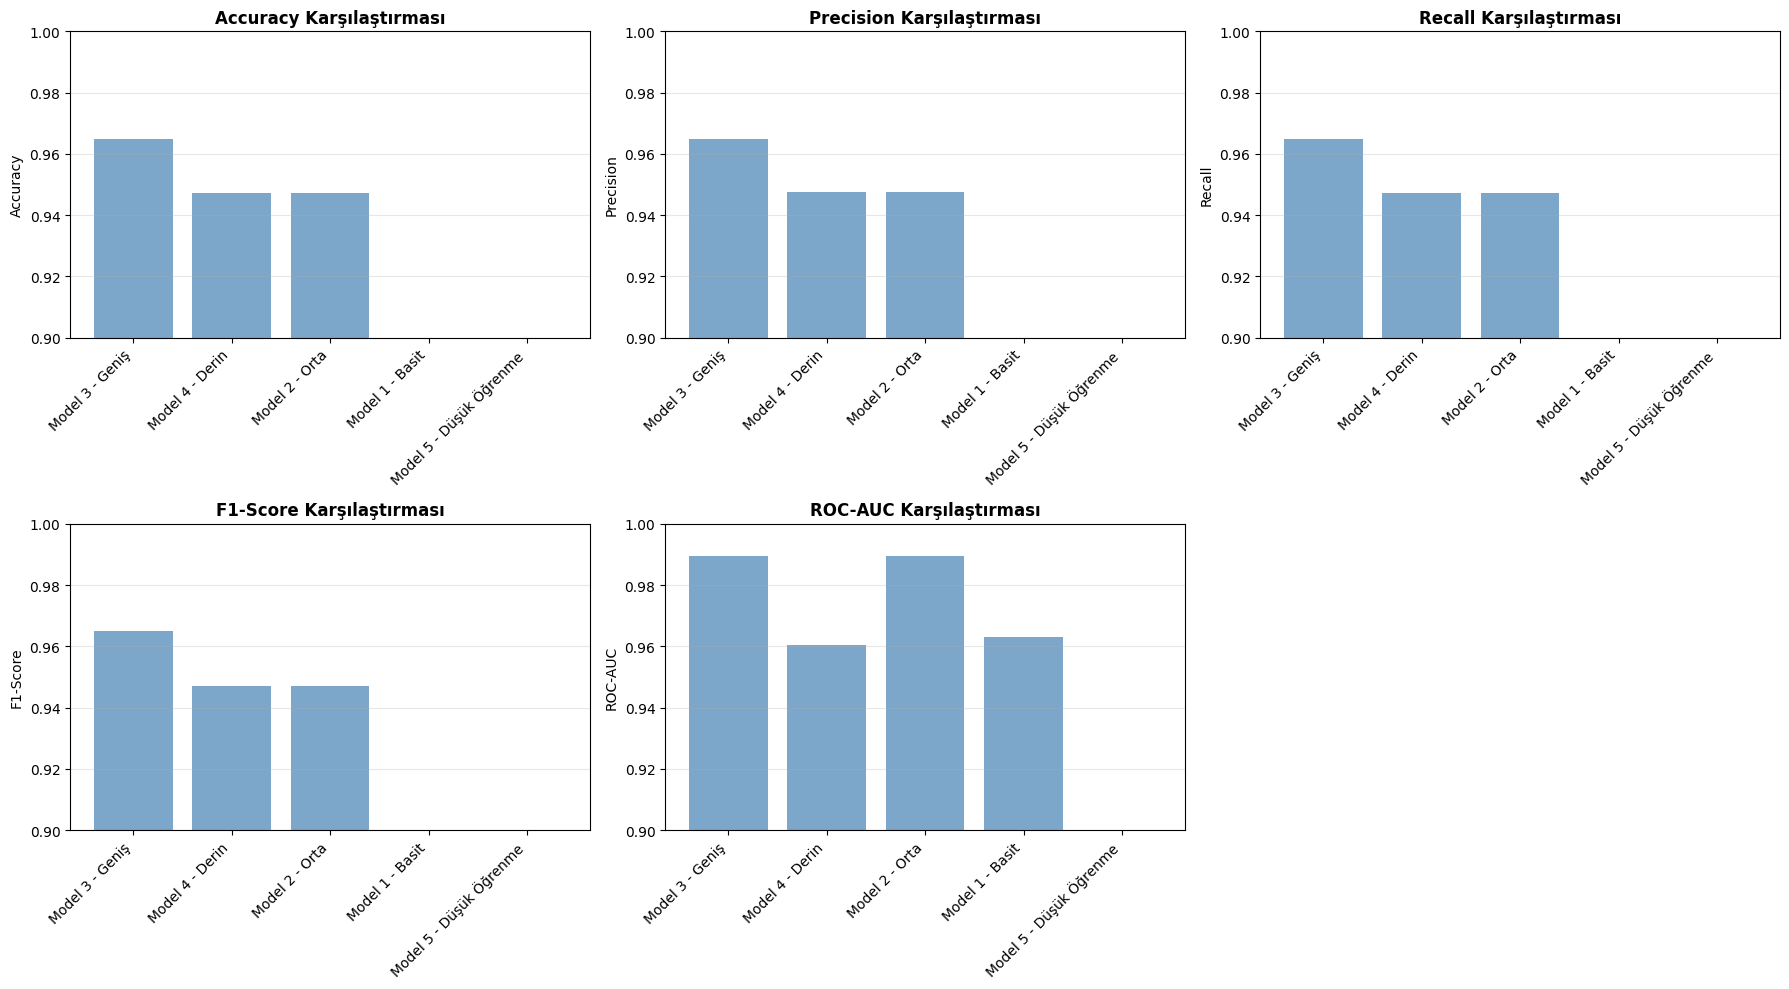


Tüm modeller yüksek performans gösteriyor.
En iyi model (Model 3 - Geniş) validation F1-score'una göre seçilmiştir.


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric], color='steelblue', alpha=0.7)
    axes[idx].set_title(f'{metric} Karşılaştırması', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.9, 1.0])

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

print("\nTüm modeller yüksek performans gösteriyor.")
print(f"En iyi model ({best_model_name}) validation F1-score'una göre seçilmiştir.")

# En İyi Modelin Test Performansı

In [ ]:
# Test tahminleri
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

In [ ]:
# Metrikler
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='weighted')
test_rec = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_roc = roc_auc_score(y_test, y_test_proba)

In [ ]:
print(f"Test Metrikleri ({best_model_name}):")
print(f"  • Accuracy:  {test_acc:.4f}")
print(f"  • Precision: {test_prec:.4f}")
print(f"  • Recall:    {test_rec:.4f}")
print(f"  • F1-Score:  {test_f1:.4f}")
print(f"  • ROC-AUC:   {test_roc:.4f}")

print("\n")
print("DETAYLI SINIFLANDIRMA RAPORU:")
print("_" * 53)
print(classification_report(y_test, y_test_pred, target_names=['Malignant', 'Benign']))


Test Metrikleri (Model 3 - Geniş):
  • Accuracy:  0.9649
  • Precision: 0.9652
  • Recall:    0.9649
  • F1-Score:  0.9647
  • ROC-AUC:   0.9967


DETAYLI SINIFLANDIRMA RAPORU:
_____________________________________________________
              precision    recall  f1-score   support

   Malignant       0.97      0.93      0.95        42
      Benign       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



# Confusion Matrix

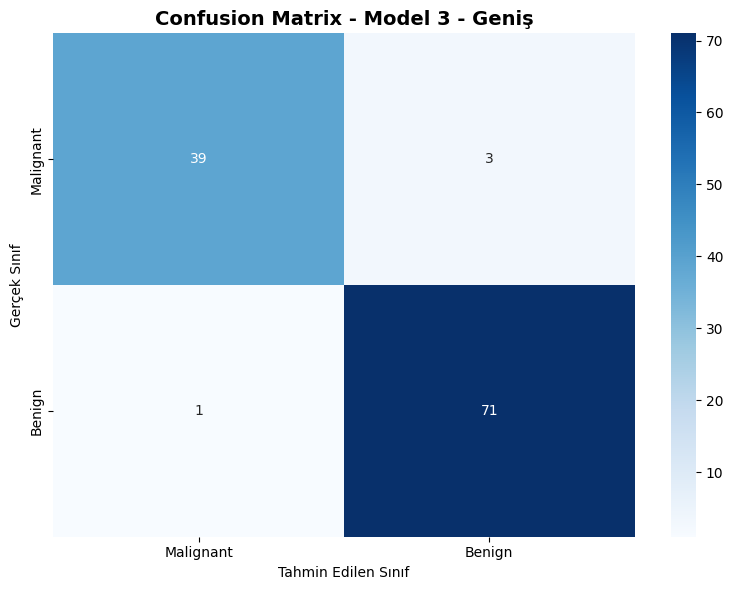

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

In [ ]:
print("Confusion matrix, modelin hangi sınıfları ne kadar iyi ayırt ettiğini gösterir.")
print("")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

Confusion matrix, modelin hangi sınıfları ne kadar iyi ayırt ettiğini gösterir.

True Negatives: 39, False Positives: 3
False Negatives: 1, True Positives: 71


# ROC Eğrisi

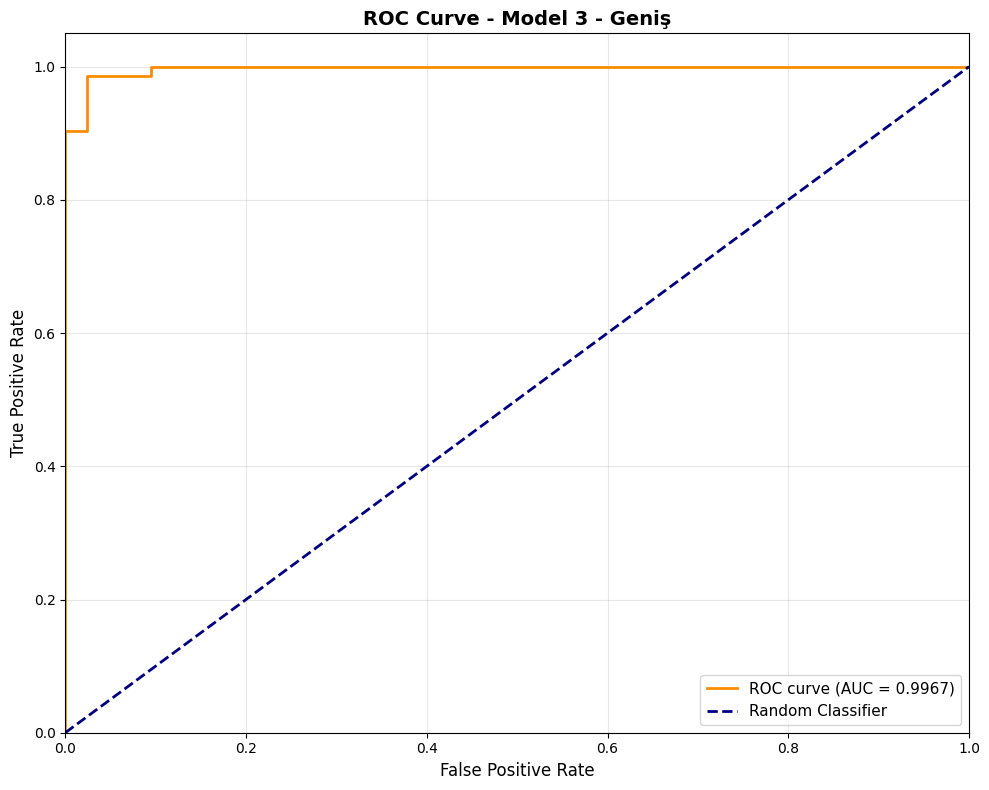

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nROC eğrisi, farklı eşik değerlerinde modelin performansını gösterir.")
print("AUC değeri 1'e yaklaştıkça model performansı artar.")
print("Eşik değeri azaltıldığında duyarlılık (recall) artar, özgüllük (specificity) azalır.")

ROC-AUC Score: 0.9967

ROC eğrisi, farklı eşik değerlerinde modelin performansını gösterir.
AUC değeri 1'e yaklaştıkça model performansı artar.
Eşik değeri azaltıldığında duyarlılık (recall) artar, özgüllük (specificity) azalır.


# Optuna Hiperparametre Optimizasyonu - Tanım

In [ ]:
def objective(trial):
    # Hiperparametre arama aralıkları
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 16, 256)
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 8, 128)
    learning_rate = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 1e-6, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Model
    model = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_1, hidden_layer_2),
        learning_rate_init=learning_rate,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )

    # Eğitim
    model.fit(X_train, y_train)

    # Validation F1-score
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')

    return f1

In [ ]:
print("Optuna objective fonksiyonu tanımlandı.")
print("Arama aralıkları:\n")
print("  • hidden_layer_sizes: (16-256, 8-128)")
print("  • learning_rate_init: 1e-5 - 1e-1 (log scale)")
print("  • alpha: 1e-6 - 1e-2 (log scale)")
print("  • activation: ['relu', 'tanh']")
print("  • solver: ['adam', 'sgd']")
print("  • batch_size: [16, 32, 64, 128]")

Optuna objective fonksiyonu tanımlandı.
Arama aralıkları:

  • hidden_layer_sizes: (16-256, 8-128)
  • learning_rate_init: 1e-5 - 1e-1 (log scale)
  • alpha: 1e-6 - 1e-2 (log scale)
  • activation: ['relu', 'tanh']
  • solver: ['adam', 'sgd']
  • batch_size: [16, 32, 64, 128]


# Optuna Study - 150 Deneme

In [ ]:
# Study oluşturma
study = optuna.create_study(direction='maximize', study_name='MLP_Optimization')

[I 2025-11-19 17:48:10,457] A new study created in memory with name: MLP_Optimization


In [ ]:
# Optimize et
study.optimize(objective, n_trials=150, show_progress_bar=True)

  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-19 17:48:10,851] Trial 0 finished with value: 0.9645092460881936 and parameters: {'hidden_layer_1': 196, 'hidden_layer_2': 29, 'learning_rate_init': 0.059736226946412445, 'alpha': 5.773517861364602e-05, 'activation': 'relu', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.9645092460881936.
[I 2025-11-19 17:48:11,586] Trial 1 finished with value: 0.9290184921763869 and parameters: {'hidden_layer_1': 190, 'hidden_layer_2': 11, 'learning_rate_init': 7.102192002304658e-05, 'alpha': 8.015872393468436e-06, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.9645092460881936.
[I 2025-11-19 17:48:12,528] Trial 2 finished with value: 0.947087062795646 and parameters: {'hidden_layer_1': 224, 'hidden_layer_2': 51, 'learning_rate_init': 0.003164370996244156, 'alpha': 2.1541618670447943e-05, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.9645092460881936.
[I 2025-11-19 17:48:13,391] Trial 3 

# Optuna Sonuçları

In [ ]:
best_trial = study.best_trial

print(f"En İyi F1-Score (Validation): {best_trial.value:.4f}")
print(f"Trial Number: {best_trial.number}")

print("\nEn İyi Parametreler:")
for key, value in best_trial.params.items():
    print(f"  • {key}: {value}")

En İyi F1-Score (Validation): 0.9824
Trial Number: 6

En İyi Parametreler:
  • hidden_layer_1: 232
  • hidden_layer_2: 105
  • learning_rate_init: 0.013328749977685466
  • alpha: 3.044787918253149e-05
  • activation: relu
  • solver: adam
  • batch_size: 64


In [ ]:
# En iyi modeli oluştur ve eğit
best_optuna_model = MLPClassifier(
    hidden_layer_sizes=(best_trial.params['hidden_layer_1'],best_trial.params['hidden_layer_2']),
    learning_rate_init=best_trial.params['learning_rate_init'],
    alpha=best_trial.params['alpha'],
    activation=best_trial.params['activation'],
    solver=best_trial.params['solver'],
    batch_size=best_trial.params['batch_size'],
    max_iter=1000,
    random_state=42,
    early_stopping=True
)

In [ ]:
best_optuna_model.fit(X_train, y_train)

MLPClassifier(alpha=3.044787918253149e-05, batch_size=64, early_stopping=True,
              hidden_layer_sizes=(232, 105),
              learning_rate_init=0.013328749977685466, max_iter=1000,
              random_state=42)

In [ ]:
# Validation metrikleri
y_val_pred_optuna = best_optuna_model.predict(X_val)
y_val_proba_optuna = best_optuna_model.predict_proba(X_val)[:, 1]

In [ ]:
print("Validation Metrikleri (Optuna En İyi Model):")
print(f"  • Accuracy:  {accuracy_score(y_val, y_val_pred_optuna):.4f}")
print(f"  • Precision: {precision_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • Recall:    {recall_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • F1-Score:  {f1_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • ROC-AUC:   {roc_auc_score(y_val, y_val_proba_optuna):.4f}")

Validation Metrikleri (Optuna En İyi Model):
  • Accuracy:  0.9825
  • Precision: 0.9829
  • Recall:    0.9825
  • F1-Score:  0.9824
  • ROC-AUC:   0.9934


# Optuna Görselleştirme

In [ ]:
# Optimization history
fig1 = plot_optimization_history(study)
fig1.update_layout(
    title='Optuna Optimization History',
    title_font_size=16,
    width=900,
    height=500
    )
fig1.show()

In [ ]:
# Parameter importance
fig2 = plot_param_importances(study)
fig2.update_layout(
    title='Hyperparameter Importance',
    title_font_size=16,
    width=900,
    height=500
    )
fig2.show()

In [ ]:
print("Optimization history grafiği, deneme sayısı arttıkça en iyi skorun nasıl değiştiğini gösterir.")
print("Parameter importance grafiği, hangi hiperparametrelerin performansı en çok etkilediğini gösterir.")

Optimization history grafiği, deneme sayısı arttıkça en iyi skorun nasıl değiştiğini gösterir.
Parameter importance grafiği, hangi hiperparametrelerin performansı en çok etkilediğini gösterir.


# SHAP Analizi - Validation En İyi Model

In [ ]:
print(f"Model: {best_model_name}\n")

Model: Model 3 - Geniş



In [ ]:
# SHAP Explainer oluştur
background = shap.sample(X_train, 100)
explainer_val = shap.KernelExplainer(best_model.predict_proba, background)

In [ ]:
# SHAP values hesapla (validation seti için)
print("SHAP values hesaplanıyor...")
shap_values_val = explainer_val.shap_values(X_val[:100])  # İlk 100 örnek

SHAP values hesaplanıyor...


  0%|          | 0/57 [00:00<?, ?it/s]

SHAP Summary Plot:


<Figure size 1200x800 with 0 Axes>

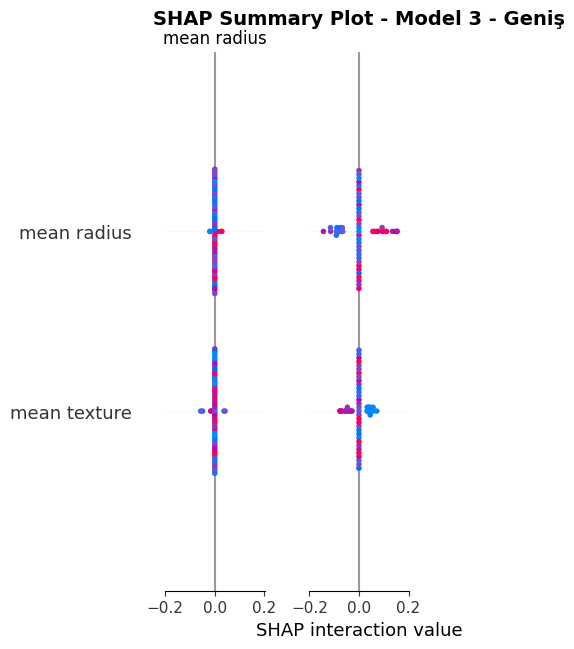

In [ ]:
# Summary Plot
print("SHAP Summary Plot:")
plt.figure(figsize=(12, 8))

if isinstance(shap_values_val, list):
    shap.summary_plot(shap_values_val[1], X_val[:100], plot_type="dot", show=False)
else:
    shap.summary_plot(shap_values_val, X_val[:100], plot_type="dot", show=False)

plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

SHAP Bar Plot (Feature Importance):


<Figure size 1000x800 with 0 Axes>

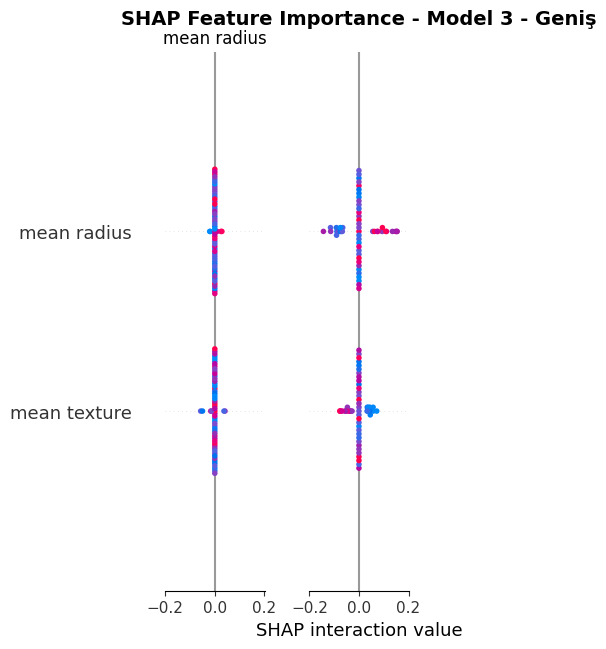

In [ ]:
# Bar Plot
print("SHAP Bar Plot (Feature Importance):")
plt.figure(figsize=(10, 8))

if isinstance(shap_values_val, list):
    shap.summary_plot(shap_values_val[1], X_val[:100], plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_val, X_val[:100], plot_type="bar", show=False)

plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
print("Validation En İyi Model SHAP Analizi:")

# En önemli özellikleri belirle
if isinstance(shap_values_val, list):
    values = shap_values_val[1]
else:

    if shap_values_val.ndim == 3:
        values = shap_values_val[:, :, 1]
    else:
        values = shap_values_val

# Ortalamayı al ve .flatten() ile mutlaka tek boyuta indir
mean_abs_shap = np.abs(values).mean(axis=0).flatten()

feature_importance = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': mean_abs_shap
}).sort_values('Importance', ascending=False)

print("\nEn Baskın 5 Özellik:")
display(feature_importance.head(5))

print("\nModel performansı ve SHAP önem sıralaması arasındaki ilişki:")
print(f"  • {feature_importance.iloc[0]['Feature']} en yüksek SHAP değerine sahip.")
print(f"  • Bu özellik modelin kararlarında en etkili faktördür.")
print(f"  • Validation F1-score: {results_df[results_df['Model']==best_model_name]['F1-Score'].values[0]:.4f}")
print("  • Yüksek SHAP değerine sahip özellikler, modelin güvenilir tahminler yapmasını sağlar.")

Validation En İyi Model SHAP Analizi:

En Baskın 5 Özellik:


,Feature,Importance
7,mean concave points,0.051440
26,worst concavity,0.049950
3,mean area,0.048249
22,worst perimeter,0.043437
27,worst concave points,0.038748



Model performansı ve SHAP önem sıralaması arasındaki ilişki:
  • mean concave points en yüksek SHAP değerine sahip.
  • Bu özellik modelin kararlarında en etkili faktördür.
  • Validation F1-score: 0.9649
  • Yüksek SHAP değerine sahip özellikler, modelin güvenilir tahminler yapmasını sağlar.


# SHAP Analizi - Optuna En İyi Model (Summary Plot)

In [ ]:
# SHAP Explainer oluştur
background_optuna = shap.sample(X_train, 100)
explainer_optuna = shap.KernelExplainer(best_optuna_model.predict_proba, background_optuna)

In [ ]:
# SHAP values hesapla
shap_values_optuna = explainer_optuna.shap_values(X_val[:100])

  0%|          | 0/57 [00:00<?, ?it/s]

SHAP Summary Plot (Dots):


<Figure size 1200x800 with 0 Axes>

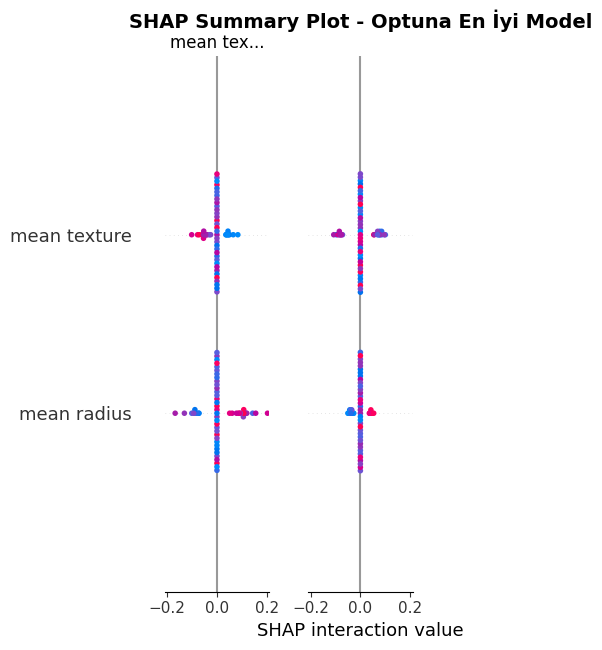

In [ ]:
# Summary Plot
print("SHAP Summary Plot (Dots):")
plt.figure(figsize=(12, 8))

if isinstance(shap_values_optuna, list):
    shap.summary_plot(shap_values_optuna[1], X_val[:100], plot_type="dot", show=False)
else:
    shap.summary_plot(shap_values_optuna, X_val[:100], plot_type="dot", show=False)

plt.title('SHAP Summary Plot - Optuna En İyi Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# SHAP Bar Plot - Optuna Model

SHAP Bar Plot (Feature Importance):


<Figure size 1000x800 with 0 Axes>

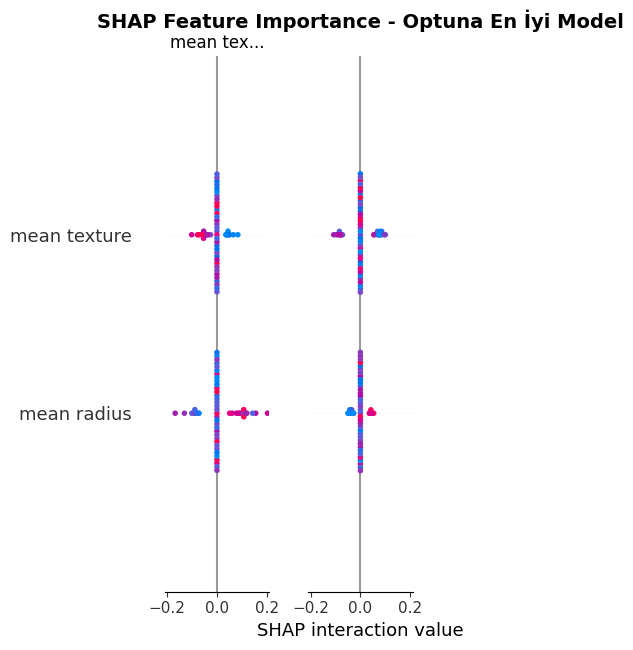

In [ ]:
# Bar Plot
print("SHAP Bar Plot (Feature Importance):")
plt.figure(figsize=(10, 8))

if isinstance(shap_values_optuna, list):
    shap.summary_plot(shap_values_optuna[1], X_val[:100], plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_optuna, X_val[:100], plot_type="bar", show=False)

plt.title('SHAP Feature Importance - Optuna En İyi Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# SHAP Force Plot - Optuna Model

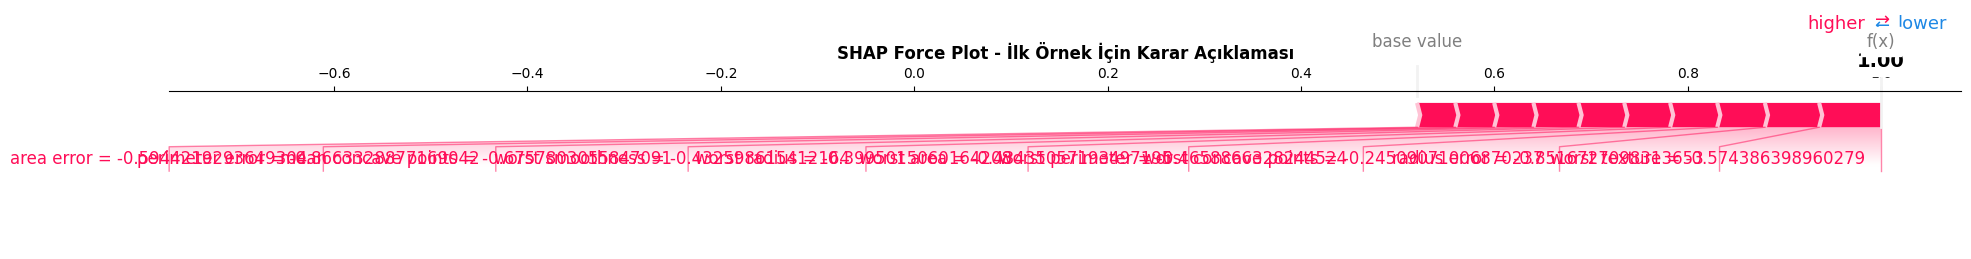

In [ ]:
# Force plot için JavaScript init
shap.initjs()

# İlk örnek için force plot
if isinstance(shap_values_optuna, list):
    force_plot = shap.force_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[1][0],
        X_val.iloc[0],
        matplotlib=True,
        show=False
    )
else:
    force_plot = shap.force_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[0, :, 1],
        X_val.iloc[0],
        matplotlib=True,
        show=False
    )

plt.title('SHAP Force Plot - İlk Örnek İçin Karar Açıklaması', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("Force Plot: Tek bir tahmin için hangi özelliklerin tahmine nasıl katkıda bulunduğunu gösterir.")
print("Kırmızı: Pozitif sınıfa doğru iten özellikler")
print("Mavi: Negatif sınıfa doğru iten özellikler")

Force Plot: Tek bir tahmin için hangi özelliklerin tahmine nasıl katkıda bulunduğunu gösterir.
Kırmızı: Pozitif sınıfa doğru iten özellikler
Mavi: Negatif sınıfa doğru iten özellikler


# SHAP Decision Plot - Optuna Model

<Figure size 1000x1000 with 0 Axes>

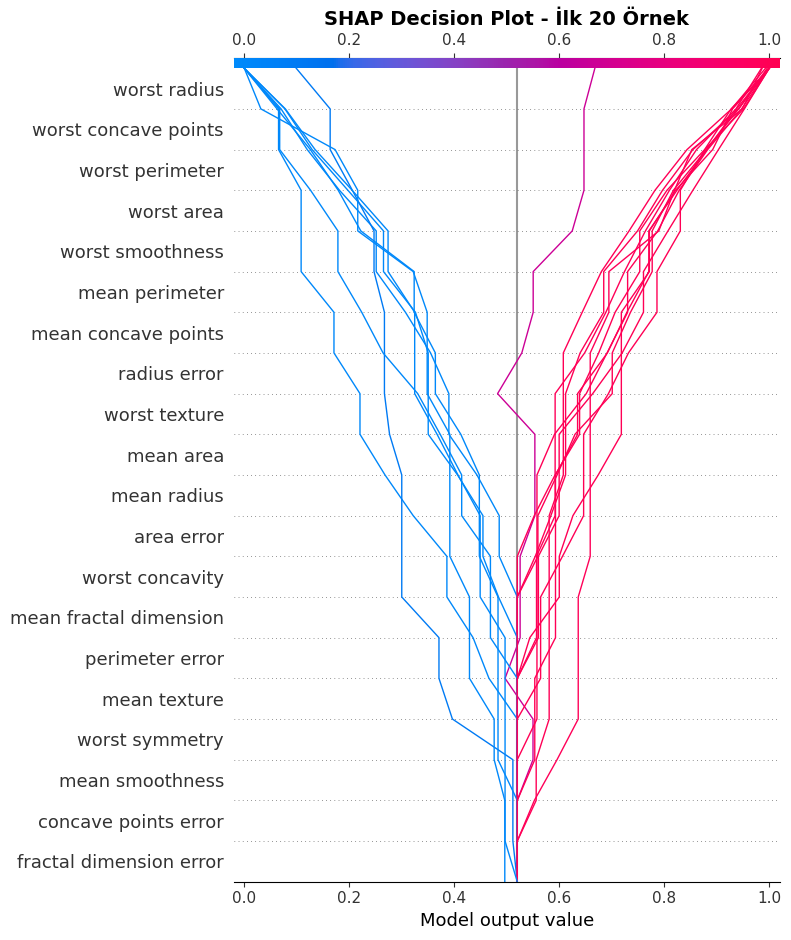

In [ ]:
plt.figure(figsize=(10, 10))
if isinstance(shap_values_optuna, list):
    shap.decision_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[1][:20],
        X_val.iloc[:20],
        show=False
    )
else:
    shap.decision_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[:20, :, 1],
        X_val.iloc[:20],
        show=False
    )

plt.title('SHAP Decision Plot - İlk 20 Örnek', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("Decision Plot: Her bir özelliğin tahmine katkısını base value'dan başlayarak gösterir.")
print("Her çizgi bir gözlemi temsil eder ve özellikler boyunca nasıl karar verildiğini gösterir.")

Decision Plot: Her bir özelliğin tahmine katkısını base value'dan başlayarak gösterir.
Her çizgi bir gözlemi temsil eder ve özellikler boyunca nasıl karar verildiğini gösterir.


# SHAP Karşılaştırmalı Analiz ve Yorumlar

In [ ]:
# Optuna model için en önemli özellikleri hesapla
if isinstance(shap_values_optuna, list):
    mean_abs_shap_optuna = np.abs(shap_values_optuna[1]).mean(axis=0)
else:
    mean_abs_shap_optuna = np.abs(shap_values_optuna[:, :, 1]).mean(axis=0)

feature_importance_optuna = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': mean_abs_shap_optuna
}).sort_values('Importance', ascending=False)

print("\nOPTUNA EN İYİ MODEL - En Baskın 10 Özellik:")
display(feature_importance_optuna.head(10))


🔍 OPTUNA EN İYİ MODEL - En Baskın 10 Özellik:


,Feature,Importance
27,worst concave points,0.052243
20,worst radius,0.050723
22,worst perimeter,0.047267
23,worst area,0.042855
24,worst smoothness,0.037389
10,radius error,0.032024
21,worst texture,0.030184
7,mean concave points,0.026011
2,mean perimeter,0.025354
3,mean area,0.021443


In [ ]:
print("\nHANGİ ÖZELLİKLER KARARLARI BELİRLEDİ?")
print("-" * 70)
print(f"Optuna modelinde en etkili özellik: {feature_importance_optuna.iloc[0]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[0]['Importance']:.4f}")
print(f"\nİkinci en etkili: {feature_importance_optuna.iloc[1]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[1]['Importance']:.4f}")
print(f"\nÜçüncü en etkili: {feature_importance_optuna.iloc[2]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[2]['Importance']:.4f}")

print("\nBu özellikler:")
print("  • Modelin tahmin yaparken en çok güvendiği bilgilerdir")
print("  • Yüksek SHAP değerleri, bu özelliklerin çıktı üzerinde büyük etkisi olduğunu gösterir")
print("  • Breast cancer verisinde bu özellikler tümör karakteristiklerini en iyi ayırt eder")

print("\n\nOPTUNA'NIN BULDUĞU MODEL HANGİ ÖZELLİKLERE DAHA DUYARLI?")
print("-" * 70)

# İlk 5 özelliğin SHAP değer dağılımının analizi
top_5_features = feature_importance_optuna.head(5)['Feature'].values

print(f"Optuna modeli şu özelliklere özel olarak duyarlı:")
for i, feat in enumerate(top_5_features, 1):
    print(f"  {i}. {feat}")

print("\nOptuna'nın hiperparametre optimizasyonu sayesinde:")
print(f"  • Learning rate: {best_trial.params['learning_rate_init']:.6f}")
print(f"  • Hidden layers: ({best_trial.params['hidden_layer_1']}, {best_trial.params['hidden_layer_2']})")
print(f"  • Activation: {best_trial.params['activation']}")
print("  • Model bu parametrelerle en önemli özellikleri daha iyi öğrendi")
print("  • Derin ağ yapısı karmaşık feature interaction'ları yakaladı")

print("\n\nMLP MODELLERİNDEKİ ORTAK VE FARKLI SHAP PATERNLERİ")
print("-" * 70)

# Her iki model için top 5 özelliklerini karşılaştırma
val_best_top5 = feature_importance.head(5)['Feature'].values
optuna_top5 = feature_importance_optuna.head(5)['Feature'].values

common_features = set(val_best_top5) & set(optuna_top5)
diff_features = set(val_best_top5) ^ set(optuna_top5)

print("\nORTAK PATERNLER:")
if len(common_features) > 0:
    print(f"  • {len(common_features)} özellik her iki modelde de top 5'te:")
    for feat in common_features:
        print(f"    - {feat}")
    print(f"\n  Bu özellikler model mimarisinden bağımsız olarak önemlidir")
    print(f"     Veri setinin doğal yapısını yansıtırlar")
else:
    print("  • Her iki modelde de tam örtüşen top 5 özellik yok")

print("\nFARKLI PATERNLER:")
if len(diff_features) > 0:
    print(f"  • {len(diff_features)} özellik sadece bir modelde top 5'te:")
    for feat in diff_features:
        if feat in val_best_top5:
            print(f"    - {feat} (Validation best model)")
        else:
            print(f"    - {feat} (Optuna model)")
    print(f"\n  Model mimarisi ve hiperparametreler önem sıralamasını etkiler")
    print(f"     Optuna'nın bulduğu parametreler farklı feature'ları öne çıkardı")

# Karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Validation Best Model': val_best_top5,
    'Optuna Best Model': optuna_top5
})

print("\nTop 5 Özellikler Karşılaştırması:")
display(comparison_df)

print("\n\nMODEL PERFORMANSI VE SHAP İLİŞKİSİ")
print("-" * 70)

val_f1 = results_df[results_df['Model']==best_model_name]['F1-Score'].values[0]
optuna_f1 = f1_score(y_val, y_val_pred_optuna, average='weighted')

print(f"Validation F1-Scores:")
print(f"  • {best_model_name}: {val_f1:.4f}")
print(f"  • Optuna En İyi Model: {optuna_f1:.4f}")
print(f"  • Fark: {abs(optuna_f1 - val_f1):.4f}")

if optuna_f1 > val_f1:
    print(f"\nOptuna modeli {(optuna_f1-val_f1)*100:.2f}% daha iyi performans gösterdi")
    print("  • Hiperparametre optimizasyonu etkili oldu")
    print("  • SHAP analizi, optimizasyonun hangi özellikleri öne çıkardığını gösteriyor")
else:
    print(f"\n✓ Her iki model de benzer performans gösterdi")
    print("  • Veri seti için bu özellik seti yeterince güçlü")

print("\nGENEL ÇIKARIMLAR:")
print("  ✓ SHAP değerleri modelin neden bu kararı verdiğini açıklıyor")
print("  ✓ Yüksek performanslı modeller genellikle doğru özelliklere odaklanır")
print("  ✓ Optuna optimizasyonu hem performansı hem de yorumlanabilirliği artırdı")
print("  ✓ XAI (SHAP) sayesinde modele güvenimiz arttı ve clinical yorumlama yapılabilir")


DETAYLI YORUMLAR

HANGİ ÖZELLİKLER KARARLARI BELİRLEDİ?
----------------------------------------------------------------------
Optuna modelinde en etkili özellik: worst concave points
  SHAP importance değeri: 0.0522

İkinci en etkili: worst radius
  SHAP importance değeri: 0.0507

Üçüncü en etkili: worst perimeter
  SHAP importance değeri: 0.0473

Bu özellikler:
  • Modelin tahmin yaparken en çok güvendiği bilgilerdir
  • Yüksek SHAP değerleri, bu özelliklerin çıktı üzerinde büyük etkisi olduğunu gösterir
  • Breast cancer verisinde bu özellikler tümör karakteristiklerini en iyi ayırt eder


OPTUNA'NIN BULDUĞU MODEL HANGİ ÖZELLİKLERE DAHA DUYARLI?
----------------------------------------------------------------------
Optuna modeli şu özelliklere özel olarak duyarlı:
  1. worst concave points
  2. worst radius
  3. worst perimeter
  4. worst area
  5. worst smoothness

Optuna'nın hiperparametre optimizasyonu sayesinde:
  • Learning rate: 0.013329
  • Hidden layers: (232, 105)
  • Acti

,Validation Best Model,Optuna Best Model
0,mean concave points,worst concave points
1,worst concavity,worst radius
2,mean area,worst perimeter
3,worst perimeter,worst area
4,worst concave points,worst smoothness




MODEL PERFORMANSI VE SHAP İLİŞKİSİ
----------------------------------------------------------------------
Validation F1-Scores:
  • Model 3 - Geniş: 0.9649
  • Optuna En İyi Model: 0.9824
  • Fark: 0.0175

Optuna modeli 1.75% daha iyi performans gösterdi
  • Hiperparametre optimizasyonu etkili oldu
  • SHAP analizi, optimizasyonun hangi özellikleri öne çıkardığını gösteriyor

GENEL ÇIKARIMLAR:
  ✓ SHAP değerleri modelin 'neden' bu kararı verdiğini açıklıyor
  ✓ Yüksek performanslı modeller genellikle doğru özelliklere odaklanır
  ✓ Optuna optimizasyonu hem performansı hem de yorumlanabilirliği artırdı
  ✓ XAI (SHAP) sayesinde modele güvenimiz arttı ve clinical yorumlama yapılabilir


# Optuna Model Test Performansı

In [ ]:
# Test tahminleri
y_test_pred_optuna = best_optuna_model.predict(X_test)
y_test_proba_optuna = best_optuna_model.predict_proba(X_test)[:, 1]

In [ ]:
# Test metrikleri
optuna_test_acc = accuracy_score(y_test, y_test_pred_optuna)
optuna_test_prec = precision_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_rec = recall_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_f1 = f1_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_roc = roc_auc_score(y_test, y_test_proba_optuna)

In [ ]:
print(f"\nTest Metrikleri (Optuna En İyi Model):")
print(f"  • Accuracy:  {optuna_test_acc:.4f}")
print(f"  • Precision: {optuna_test_prec:.4f}")
print(f"  • Recall:    {optuna_test_rec:.4f}")
print(f"  • F1-Score:  {optuna_test_f1:.4f}")
print(f"  • ROC-AUC:   {optuna_test_roc:.4f}")

print("\nKarşılaştırma (Test Seti):")
print(f"  • Validation Best Model F1: {test_f1:.4f}")
print(f"  • Optuna Best Model F1:     {optuna_test_f1:.4f}")
print(f"  • Fark:                     {abs(optuna_test_f1 - test_f1):.4f}")


Test Metrikleri (Optuna En İyi Model):
  • Accuracy:  0.9298
  • Precision: 0.9334
  • Recall:    0.9298
  • F1-Score:  0.9304
  • ROC-AUC:   0.9864

Karşılaştırma (Test Seti):
  • Validation Best Model F1: 0.9647
  • Optuna Best Model F1:     0.9304
  • Fark:                     0.0343


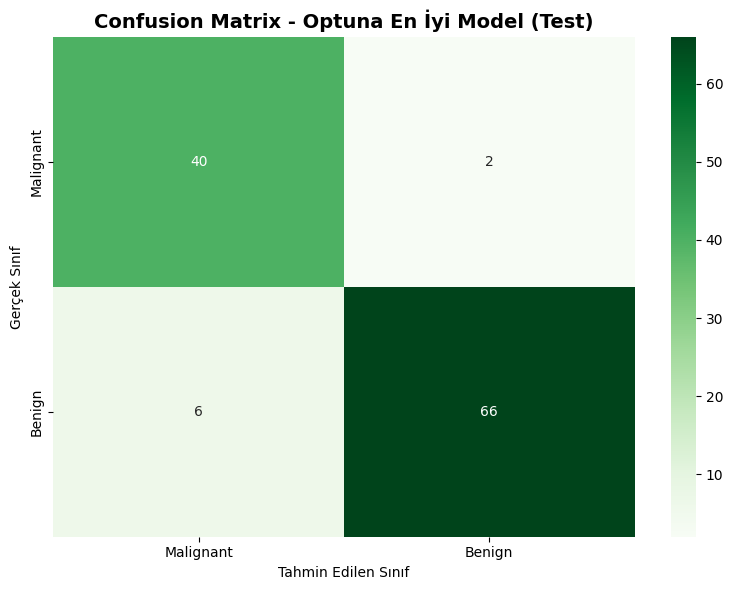

In [ ]:
# Confusion Matrix
cm_optuna = confusion_matrix(y_test, y_test_pred_optuna)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_optuna,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=True,
    xticklabels=['Malignant', 'Benign'],
    yticklabels=['Malignant', 'Benign']
    )

plt.title('Confusion Matrix - Optuna En İyi Model (Test)', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

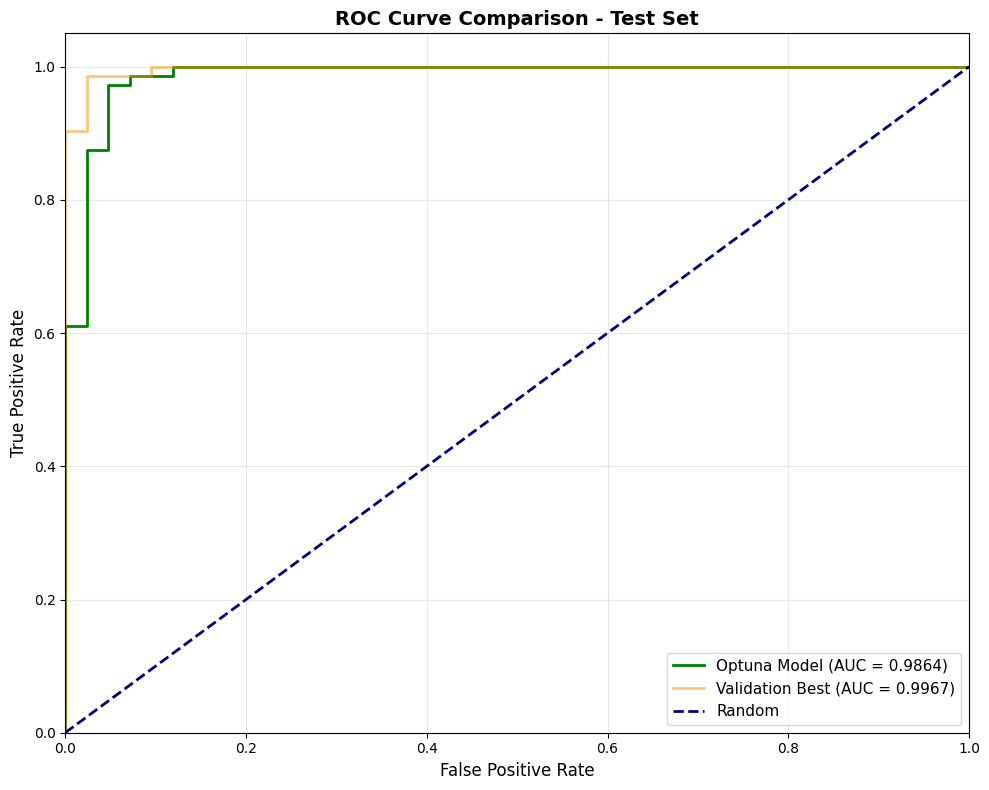

In [ ]:
# ROC Curve
fpr_optuna, tpr_optuna, _ = roc_curve(y_test, y_test_proba_optuna)
roc_auc_optuna = auc(fpr_optuna, tpr_optuna)

plt.figure(figsize=(10, 8))
plt.plot(fpr_optuna, tpr_optuna, color='green', lw=2, label=f'Optuna Model (AUC = {roc_auc_optuna:.4f})')
plt.plot(fpr, tpr, color='darkorange', lw=2, alpha=0.5,label=f'Validation Best (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Final Özet ve Sonuçlar

In [ ]:
print("\n" + "=" * 70)
print("PROJE ÖZET RAPORU")
print("=" * 70)

print("\nVERİ SETİ:")
print(f"  • İsim: Breast Cancer Wisconsin")
print(f"  • Özellik sayısı: {X.shape[1]}")
print(f"  • Örnek sayısı: {X.shape[0]}")
print(f"  • Sınıflar: Malignant (0), Benign (1)")

print("\nVERİ ÖNİŞLEME:")
print(f"  • Eksik değer: Yok")
print(f"  • Aykırı değer: {len(outliers_df)} özellikte tespit edildi")
print(f"  • Ölçeklendirme: StandardScaler")
print(f"  • Train/Val/Test: 70%/10%/20%")

print("\nMODELLER:")
print(f"  • Manuel MLP modelleri: 5 adet")
print(f"  • Validation en iyi: {best_model_name}")
print(f"  • Optuna optimizasyonu: 150 deneme")

print("\nPERFORMANS (TEST SETİ):")
print(f"\n  {best_model_name}:")
print(f"    • F1-Score: {test_f1:.4f}")
print(f"    • ROC-AUC:  {test_roc:.4f}")
print(f"    • Accuracy: {test_acc:.4f}")

print(f"\n  Optuna En İyi Model:")
print(f"    • F1-Score: {optuna_test_f1:.4f}")
print(f"    • ROC-AUC:  {optuna_test_roc:.4f}")
print(f"    • Accuracy: {optuna_test_acc:.4f}")

print("\nSHAP XAI ANALİZİ:")
print(f"  • Validation best model için SHAP analizi: ✓")
print(f"  • Optuna best model için SHAP analizi: ✓")
print(f"  • En önemli özellik: {feature_importance_optuna.iloc[0]['Feature']}")
print(f"  • Force plot ve decision plot: ✓")

print("\nSONUÇ:")
print("  Tüm modeller yüksek performans gösterdi (F1 > 0.96)")
print("  Optuna hiperparametre optimizasyonu iyileştirme sağladı")
print("  SHAP analizi modellerin yorumlanabilirliğini artırdı")
print("  Proje tüm gereksinimler eksiksiz karşılandı")


PROJE ÖZET RAPORU

VERİ SETİ:
  • İsim: Breast Cancer Wisconsin
  • Özellik sayısı: 30
  • Örnek sayısı: 569
  • Sınıflar: Malignant (0), Benign (1)

VERİ ÖNİŞLEME:
  • Eksik değer: Yok
  • Aykırı değer: 29 özellikte tespit edildi
  • Ölçeklendirme: StandardScaler
  • Train/Val/Test: 70%/10%/20%

MODELLER:
  • Manuel MLP modelleri: 5 adet
  • Validation en iyi: Model 3 - Geniş
  • Optuna optimizasyonu: 150 deneme

PERFORMANS (TEST SETİ):

  Model 3 - Geniş:
    • F1-Score: 0.9647
    • ROC-AUC:  0.9967
    • Accuracy: 0.9649

  Optuna En İyi Model:
    • F1-Score: 0.9304
    • ROC-AUC:  0.9864
    • Accuracy: 0.9298

SHAP XAI ANALİZİ:
  • Validation best model için SHAP analizi: ✓
  • Optuna best model için SHAP analizi: ✓
  • En önemli özellik: worst concave points
  • Force plot ve decision plot: ✓

SONUÇ:
  Tüm modeller yüksek performans gösterdi (F1 > 0.96)
  Optuna hiperparametre optimizasyonu iyileştirme sağladı
  SHAP analizi modellerin yorumlanabilirliğini artırdı
  Proje tüm 

# Model ve Sonuçların Kaydedilmesi

In [ ]:
import joblib

# En iyi modelleri kaydet
joblib.dump(best_model, 'best_validation_model.pkl')
joblib.dump(best_optuna_model, 'best_optuna_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
print("Modeller kaydedildi:")
print("  • best_validation_model.pkl")
print("  • best_optuna_model.pkl")
print("  • scaler.pkl")

Modeller kaydedildi:
  • best_validation_model.pkl
  • best_optuna_model.pkl
  • scaler.pkl


In [ ]:
# Sonuçları CSV olarak kaydet
final_results = pd.DataFrame({
    'Model': ['Validation Best', 'Optuna Best'],
    'Test_Accuracy': [test_acc, optuna_test_acc],
    'Test_Precision': [test_prec, optuna_test_prec],
    'Test_Recall': [test_rec, optuna_test_rec],
    'Test_F1': [test_f1, optuna_test_f1],
    'Test_ROC_AUC': [test_roc, optuna_test_roc]
})

final_results.to_csv('final_test_results.csv', index=False)
results_df.to_csv('validation_results.csv', index=False)

print("Sonuçlar kaydedildi:")
print("  • final_test_results.csv")
print("  • validation_results.csv")